In [57]:
#EKF that estimates following state: x[q;v;ρ]

#scaling positions to km
#scaling velocities to km/s
#scaling atmospheric density to kg/km3


#State Estimator assuming GPS measurments
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using BenchmarkTools

In [58]:
#accurate dynamics

#epc is the current epoch (current time), and x is the state

#accurate dynamics. considers gravity, J2, drag, solar radiation
#pressure, and the effect of other bodies (sun/moon)

#ẋ = f(x,t)
function ground_truth_sat_dynamics(x, epc)
    
    r = x[1:3] #satellite position in inertial frame
    v = x[4:6] #satellite velocity in inertial frame
        
    #look up this term. seems to give a rotation matrix
    PN = bias_precession_nutation(epc)
    Earth_r    = earth_rotation(epc)
    rpm  = polar_motion(epc) 

    R = rpm*Earth_r*PN
    
    #compute the 3x3 rotation matrix from ECI to ECEF 
    #R = rECItoECEF(epc)
    
    
    #Compute the sun and moon positions in ECI frame
    r_sun = sun_position(epc)
    r_moon = moon_position(epc)
    
    #define the acceleration variable
    a = zeros(eltype(x), 3)
    
    #compute acceleration caused by Earth gravity (includes J2)
    #modeled by a spherical harmonic gravity field
    n_grav = 10
    m_grav = 10
    #main contribution in acceleration
    a+= accel_gravity(x, R, n_grav, m_grav)
    
    #atmospheric drag
    #compute the atmospheric density from density harris priester model
    #ρ = density_harris_priester(epc,r)
    #ρ = 1.15e-12 #fixed atmospheric density in kg/m3
    #testing rho
    ρ = 5e-11
    
    #computes acceleration due to drag in inertial directions
    
    cd = 2.0 #drag coefficient
    area_drag = 0.1 #in m2 #area normal to the velocity direction
    m = 1.0
    
    a += accel_drag(x, ρ, m, area_drag, cd, Array{Real,2}(PN))
        
    #print("this is modeled effects: ", a_grav+a_drag)
    #Solar Radiation Pressure
    #nu = eclipse_conical(x, r_sun) #what is this for
    area_srp = 1.0
    coef_srp = 1.8
    #COMMENTED FOR TESTING
    #a += accel_srp(x, r_sun, m, area_srp, coef_srp)
    a_srp = accel_srp(x, r_sun, m, area_srp, coef_srp)
    #acceleration due to external bodies
    
    #COMMENTED FOR TESTING
    #a+= accel_thirdbody_sun(x, r_sun)
    a_sun = accel_thirdbody_sun(x, r_sun)
    
    #COMMENTED FOR TESTING
    #a+= accel_thirdbody_moon(x, r_moon)
    a_moon = accel_thirdbody_moon(x, r_moon)
    
    a_unmodeled = a_srp + a_sun + a_moon
            
    xdot = x[4:6]
    vdot = a
    
    x_dot = [xdot; vdot]
    
    return x_dot, a_unmodeled, ρ
    
end

ground_truth_sat_dynamics (generic function with 1 method)

In [59]:
#from SMAD. The minimum and maximum atmospheric density values are the following. Given solar flares
ρ_max = 5e-11 #in kg/km3
ρ_min = 5e-11 #in kg/km3

5.0e-11

In [60]:
function RK4(x, t, h)
    
    f1,_, _ = ground_truth_sat_dynamics(x, t) 
    f2,_, _ = ground_truth_sat_dynamics(x+0.5*h*f1, t+h/2)
    f3,_, _ = ground_truth_sat_dynamics(x+0.5*h*f2, t+h/2)
    f4,_, _ = ground_truth_sat_dynamics(x+h*f3, t+h)
    
    xnext = x+(h/6.0)*(f1+2*f2+2*f3+f4)
        
    return xnext
    
end

RK4 (generic function with 1 method)

In [61]:
# initial time for sim
epc0 = Epoch(2012, 11, 8, 12, 0, 0, 0.0)

Epoch(2012-11-08T11:59:25.000Z)

In [62]:
#Test of some of the SatelliteDynamics functions

#Orbit we want (around ISS orbit conditions)
iss1 = [6871e3, 0.00064, 51.6450, 1.0804, 27.7899, 190]; 

# Convert osculating elements to Cartesean state
# returns position and velocity (m, m/s). This is the intial position
eci0_1 = sOSCtoCART(iss1, use_degrees=true)

#find the period of the orbit (seconds). only dependent on semi major axis
T = orbit_period(iss1[1])

#final time
epcf = epc0 + T

Epoch(2012-11-08T13:33:53.144Z)

In [63]:
#print(T/60/60)

In [64]:
eci0_1

6-element Vector{Float64}:
    -5.384009806494038e6
    -2.715541505256187e6
    -3.3027935472528217e6
  4733.13249886581
 -3644.4068768958364
 -4717.485677232028

In [65]:
function satdynamics_rk4(x0, Tf, h)
    
    t = Array(range(0,Tf, step=h)) #create a range to final time at constant time step
    
    all_x = zeros(length(x0), length(t)) #variable to store all x
    
    all_x[:,1] .= x0 #set the initial state
    
    for k=1:(length(t) - 1)
        
        current_t = epc0+t[k] #calculate the current time
        
        all_x[:,k+1] .= RK4(all_x[:,k], current_t, h) #calculate the next state
        
    end
    
    return all_x, t
end

satdynamics_rk4 (generic function with 1 method)

In [66]:
h = 1 #1 Hz the timestep

#initial pose
x_0 = [-6.3326525733258715e6, -1.497391702793296e6, -2.2161566541800327e6, -2408.289701049338, -477.2751445951439, 7206.151917789134]
#x_0 = [-6.3326525733258715e6, -1.497391702793296e6, -2.2161566541800327e6, -2408.289701049338, -477.2751445951439, 1206.151917789134]

#x_0 = [-2.3326525733258715e6, -6.497391702793296e6, -5.2161566541800327e6, -2408.289701049338, -477.2751445951439, 7206.151917789134]

initial_orbital_elements = SatelliteDynamics.sCARTtoOSC(x_0)


orbitperiod = orbit_period(initial_orbital_elements[1])
#orbit_num = 20 #number of orbits to simulate

orbit_num = 5
Tf = orbitperiod*orbit_num

x_hist, t_hist = satdynamics_rk4(x_0, Tf, h)

([-6.3326525733258715e6 -6.335056974738165e6 … -6.431496616314539e6 -6.433499822159476e6; -1.497391702793296e6 -1.4978680585641619e6 … -1.5194020938121616e6 -1.5197850629800833e6; … ; -477.2751445951439 -475.4362981192433 … -383.9082882692081 -382.0299672472659; 7206.151917789134 7208.875933621831 … 7342.314088264731 7344.588538801696], [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  28331.0, 28332.0, 28333.0, 28334.0, 28335.0, 28336.0, 28337.0, 28338.0, 28339.0, 28340.0])

In [67]:
initial_orbital_elements[1]

6.871e6

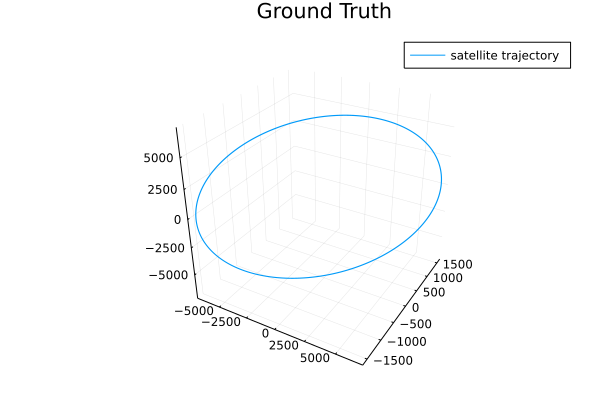

In [68]:
using Plots

x_hist_scaled = x_hist*1e-3 # get the measurment to km

plot(x_hist_scaled[1,:], x_hist_scaled[2,:], x_hist_scaled[3,:], title="Ground Truth", label="satellite trajectory")

In [69]:
t = Array(range(0,Tf, step=h)) 

all_a_unmodeled = zeros((3, length(t)))

ρ_all = zeros(length(t))

for i in 1:length(t)
    
    current_time = epc0 + t[i]
    
    ẋ, a_unmodeled, ρ_t = ground_truth_sat_dynamics(x_hist[:,i], current_time)
    
    ρ_all[i] = ρ_t
    
    all_a_unmodeled[:,i] = a_unmodeled

end

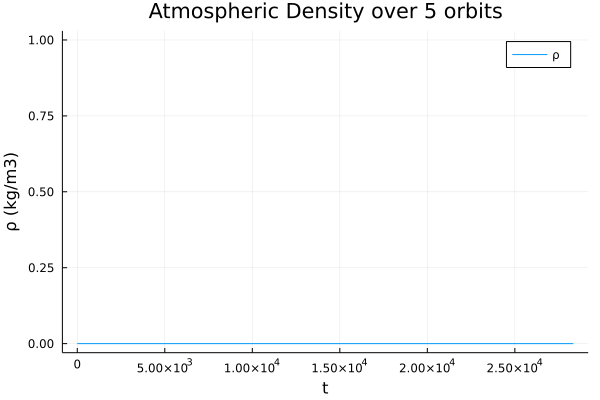

In [70]:
plot(t, ρ_all, title = "Atmospheric Density over 5 orbits", label = "ρ", xlabel = "t", ylabel = "ρ (kg/m3)")

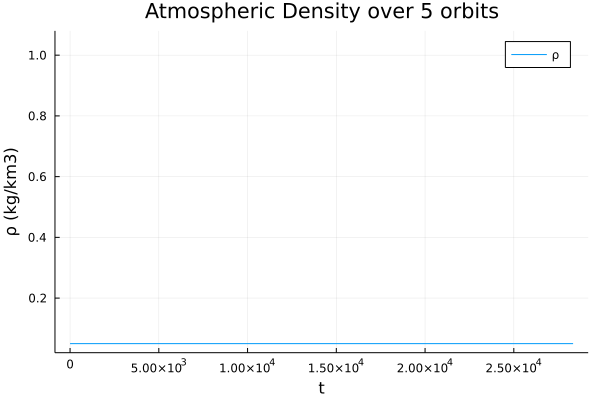

In [71]:
plot(t, ρ_all*1e9, title = "Atmospheric Density over 5 orbits", label = "ρ", xlabel = "t", ylabel = "ρ (kg/km3)")

In [72]:
#First atm density value
(ρ_all[1] - ρ_all[2])*1e9  

0.0

In [73]:
#total number of timesteps
n = length(t)

#this is the mean of the unmodeled accelerations

mean = sum(all_a_unmodeled, dims=2)/n  #dimensions of m/s

3×1 Matrix{Float64}:
 5.710078219847478e-6
 5.6177238617831595e-6
 2.4327321420819e-6

In [74]:
totalsum = zeros((3,3))

#find the covariance of the acceleration

for i in 1:n
    
    value = all_a_unmodeled[:,i] - mean
    matrixvalue = value*transpose(value)
    totalsum += matrixvalue
    
end

covariancematrix = totalsum/n

3×3 Matrix{Float64}:
  6.11301e-13  -1.22296e-13   3.52612e-14
 -1.22296e-13   4.53225e-14  -9.08786e-14
  3.52612e-14  -9.08786e-14   3.4891e-13

In [75]:
#another way to find covariance

F = [I(3);I(3)].*[ones(3)*0.5*h^2; ones(3)*h]

6×3 SparseArrays.SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 0.5   ⋅    ⋅ 
  ⋅   0.5   ⋅ 
  ⋅    ⋅   0.5
 1.0   ⋅    ⋅ 
  ⋅   1.0   ⋅ 
  ⋅    ⋅   1.0

In [76]:
R_6 = (F*covariancematrix*F')*(1e-3)^2 #change to units of km2

6×6 Matrix{Float64}:
  1.52825e-19  -3.05739e-20   8.81529e-21  …  -6.11478e-20   1.76306e-20
 -3.05739e-20   1.13306e-20  -2.27197e-20      2.26613e-20  -4.54393e-20
  8.81529e-21  -2.27197e-20   8.72276e-20     -4.54393e-20   1.74455e-19
  3.05651e-19  -6.11478e-20   1.76306e-20     -1.22296e-19   3.52612e-20
 -6.11478e-20   2.26613e-20  -4.54393e-20      4.53225e-20  -9.08786e-20
  1.76306e-20  -4.54393e-20   1.74455e-19  …  -9.08786e-20   3.4891e-19

In [77]:
R_fullstate = Matrix(1.0I, 7, 7)

#covariance of the state due to the unmodeled accelerations
R_fullstate[1:6, 1:6] = R_6


R_fullstate[7,7] = (1e-4)^2

display(R_fullstate)

7×7 Matrix{Float64}:
  1.52825e-19  -3.05739e-20  …  -6.11478e-20   1.76306e-20  0.0
 -3.05739e-20   1.13306e-20      2.26613e-20  -4.54393e-20  0.0
  8.81529e-21  -2.27197e-20     -4.54393e-20   1.74455e-19  0.0
  3.05651e-19  -6.11478e-20     -1.22296e-19   3.52612e-20  0.0
 -6.11478e-20   2.26613e-20      4.53225e-20  -9.08786e-20  0.0
  1.76306e-20  -4.54393e-20  …  -9.08786e-20   3.4891e-19   0.0
  0.0           0.0              0.0           0.0          1.0e-8

In [78]:
#data from ground truth sim (an estimate) #in m/s2
a_unmodeled = [4.7105521198913615e-6, 5.8082534718898e-6, 2.586395061844412e-6]

3-element Vector{Float64}:
 4.7105521198913615e-6
 5.8082534718898e-6
 2.586395061844412e-6

In [79]:
#errors from the dynamics
#this is the error in the velocities. multiply by the timestep, but in this case the timestep is 1
#v = a*t in meters
Δt = 1
velocity_error = norm(a_unmodeled)*Δt

#x = vt+at^2
position_error = velocity_error + norm(a_unmodeled)*Δt^2

print("velocity error: ", velocity_error)

print("position error: ", position_error)

velocity error: 7.91293555413325e-6position error: 1.58258711082665e-5

In [80]:
size(x_hist)

(6, 28341)

In [81]:
GPS_num = size(x_hist_scaled)[2]

GPS_measurments = zeros(6, GPS_num)

#generate the GPS measurments
std_GPS_pose = 10*1e-3 #in km ~10 m

std_GPS_vel = 0.1*1e-3 #in km ~0.1 m/s

for i in 1:GPS_num
    
    gps_pose_noise = randn(3)*std_GPS_pose #scale standard deviation by 10
    gps_vel_noise = randn(3)*std_GPS_vel #scale standard deviation by 0.1
    
    gps_noise = [gps_pose_noise;gps_vel_noise]
    
    GPS_measurments[:, i] = x_hist_scaled[:, i] + gps_noise 
    
end

In [82]:
size(GPS_measurments)

(6, 28341)

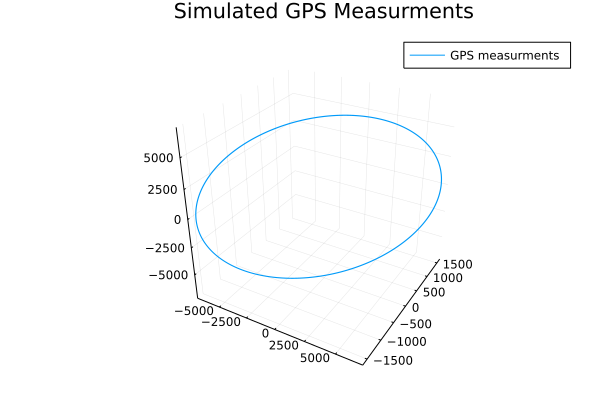

In [83]:
plot(GPS_measurments[1,:], GPS_measurments[2,:], GPS_measurments[3,:], label = "GPS measurments", title = "Simulated GPS Measurments")

In [84]:
#estimated GPS measurment given the estimated state (deterministic) 
function measurment_function(x)
    
    C = [I zeros((3,4))]
    #measurment only gives you the position of the satellite
    measurment = C*x 
    
    #only return the state of the spacecraft
    return measurment, C
end

measurment_function (generic function with 1 method)

In [85]:
#standard deviation associated to the measurment
std_gps_measurment = 10*1e-3 #in km. ~10 m

#assume that it is additive noise
Q = I(3)*(std_gps_measurment)^2 

3×3 Diagonal{Float64, Vector{Float64}}:
 0.0001   ⋅       ⋅ 
  ⋅      0.0001   ⋅ 
  ⋅       ⋅      0.0001

In [86]:
Q = convert(Matrix{Float64}, Q)

3×3 Matrix{Float64}:
 0.0001  0.0     0.0
 0.0     0.0001  0.0
 0.0     0.0     0.0001

In [87]:
#noise associated to the dynamics. (need to figure out the effect of unmodeled perturbations) 
#Trusting the dynamics more than GPS measurments
#got these measurments by integrating the dynamics and seeing the difference

pose_std_dynamics = 8e-6*1e-3 #get to km
velocity_std_dynamics = 2e-5*1e-3 #get to km/s
#ρ_noise = 0.01e-3 #in kg/km3

ρ_noise = 1e-8 #in kg/km3
#p noise originally 1e-7

#from 1 timestep to the next, the change in atmospheric density is around 1e-8 which will be taken as the
#standard deviation


#process noise
R = I(7).*[ones(3)*pose_std_dynamics^2; ones(3)*velocity_std_dynamics^2; (ρ_noise)^2]

7×7 Matrix{Float64}:
 6.4e-17  0.0      0.0      0.0      0.0      0.0      0.0
 0.0      6.4e-17  0.0      0.0      0.0      0.0      0.0
 0.0      0.0      6.4e-17  0.0      0.0      0.0      0.0
 0.0      0.0      0.0      4.0e-16  0.0      0.0      0.0
 0.0      0.0      0.0      0.0      4.0e-16  0.0      0.0
 0.0      0.0      0.0      0.0      0.0      4.0e-16  0.0
 0.0      0.0      0.0      0.0      0.0      0.0      1.0e-16

In [88]:
#jacobian of the measurment function
H = [I zeros((3,4))]

3×7 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0

In [89]:
#Implement this function in spherical coordinates
function gravitational_potential(s)
    # input: position in spherical coordinates 
    # s = [r, θ, ϕ]
    # output: gravitational potential
    
    #J2 = mu (in km) * radius of Earth^2 (km2)* J2 term
    #Constants
    μ = 398600.44 #km^3/sec^2
    J2 = 1.75553e10 #km^5/sec^2
    
    # unpack input
    r = s[1]
    θ = s[2]
    m = 1.0 #added in
    #ϕ = s[3]
    #U_off = (-μ/r) + (μ*R^2*J2/r^3)*((3/2)*(cos(θ))^2 - 0.5)
    
    # TODO: input the gravitational potential
    #U = 0.0 
    U = m*((-μ/r)+(J2*(3*(sin(θ))^2 - 1))/(2*r^3))
    
    return U
end


gravitational_potential (generic function with 1 method)

In [90]:
# conversion from cartesian coordinates to spherical coordinates
function cartesian_to_spherical(x)
    r = sqrt(x[1:3]'*x[1:3])
    θ = atan(x[3],sqrt(x[1:2]'*x[1:2]))
    ϕ = atan(x[2],x[1])
    
    return [r; θ; ϕ]
end

cartesian_to_spherical (generic function with 1 method)

In [91]:
function gravitational_acceleration(x)
    # input: position in cartesian coordiantes 
    # output: acceleration in cartesian coordiantes 
    
    # TODO: output the gravitational acceleration 
    #a = zeros(3)
    #F = - (gradient) U(x) then use a = F/m
    
    q = x[1:3]
    
    v = x[4:6]
    ρ = x[7]
    
    c_d = 2.0 #drag coefficient (dimensionless)
    
    A = 0.1*(1e-3)^2 #in km2
    
    #rotation of the earth (rad/s)
    ω_earth = [0,0, OMEGA_EARTH]
    
    v_rel = v - cross(ω_earth, q)
    
    f_drag = -0.5*c_d*(A)*ρ*norm(v_rel)*v_rel
    
    a = -(ForwardDiff.gradient(_x -> gravitational_potential(cartesian_to_spherical(_x)), q))+ f_drag
    
    return a 
end

gravitational_acceleration (generic function with 1 method)

In [92]:
function orbit_dynamics(x)
    
    q = x[1:3]
    v = x[4:6]
    
    a = gravitational_acceleration(x) #obtain the gravitational acceleration given the position q
    
    ẋ = [v; a; 0] #x dot is velocity and acceleration
    
    return ẋ
end


orbit_dynamics (generic function with 1 method)

In [93]:
function RK4_satellite_potential(x)

    h = 1.0 #time step
    f1 = orbit_dynamics(x)
    f2 = orbit_dynamics([x[1:6]+0.5*h*f1[1:6]; x[7]])
    f3 = orbit_dynamics([x[1:6]+0.5*h*f2[1:6]; x[7]])
    f4 = orbit_dynamics([x[1:6]+h*f3[1:6]; x[7]])
    xnext = x+(h/6.0)*(f1+2*f2+2*f3+f4)
    return xnext
    
end

RK4_satellite_potential (generic function with 1 method)

In [94]:
#x_0 = [1,2,3,4,5,6,2.0e-3]

#xnext = RK4_satellite_potential(x_0)

In [95]:
function find_jacobian(x_0)
    
    F = ForwardDiff.jacobian(dx -> RK4_satellite_potential(dx), x_0)

end

find_jacobian (generic function with 1 method)

In [96]:
#time it takes to run the jacobian
#@btime find_jacobian($x_0)

In [97]:
# #X is the state, P is the covariance, and k is the timestep
# function EKF_satellite(X, P, k)
    
#     #Prediction Step
#     X_pre = RK4_satellite_potential(X)

#     G = find_jacobian(X)
    
#     P_pre = G*P*G' + R
        
#     #Update Step
#     K = P_pre*H'*inv(H*P_pre'*H' + Q)
        
#     innovation = GPS_measurments[1:3, k] - measurment_function(X_pre)
        
#     X = X_pre + K*innovation
        
#     #P = (I(7) - K*H)*P_pre
    
#     A = I(7) - K*H
    
#     P = A*P_pre*A'+K*Q*K'
    
#     #P = (I(7) - K*H)*P_pre
    
#     return X, P
    
# end

In [98]:
#Formulation from Uncommon Labs
# function EKF_satellite(X, P, k)
    
#     #Prediction Step
#     X_pre = RK4_satellite_potential(X)

#     G = find_jacobian(X)
    
#     P_pre = G*P*G' + R
        
#     zk̂ = measurment_function(X_pre)
    
#     Pxy = P_pre*H'
    
#     Pyy = H*P_pre*H' + Q
    
#     K = Pxy*inv(Pyy)
    
#     #Update Step
#     #K = P_pre*H'*inv(H*P_pre'*H' + Q)
        
#     innovation = GPS_measurments[1:3, k] - zk̂
    
#     X = X_pre + K*innovation
            
#     A = I(7) - K*H
    
#     P = A*P_pre*A'+K*Q*K'
    
#     #P = (I(7) - K*H)*P_pre
    
#     return X, P
    
# end

In [99]:
#Formulation from Uncommon Labs
function EKF_satellite_QR(X, F, k)
    
    #Prediction Step
    
    #state prediction
    X_pre = RK4_satellite_potential(X)

    A = find_jacobian(X) #the A matrix from the dynamics
    
    n = [F*A'; sqrt(R)]
    
    _, F_pre = qr(n)
        
    zk̂, C = measurment_function(X_pre)
        
    innovation = GPS_measurments[1:3, k] - zk̂
    
    _, G = qr([F_pre*C';sqrt(Q)]) #mxm where m is measurement size
    
    L_inside = G\((G'\C)*F_pre'*F_pre)
    
    L = L_inside'  
        
    X = X_pre + L*innovation
    
    _, F = qr([F_pre*(I-L*C)'; sqrt(Q)*L'])
        
    return X, F
    
end

EKF_satellite_QR (generic function with 1 method)

In [100]:
#Initial State and Initial Covariance 
#uncertainty much higher in the velocity becasue there is no measuerment to update the prediction!

true_first_pose = [-6332.652573325871, -1497.391702793296, -2216.1566541800325, -2.408289701049338, -0.4772751445951439, 7.206151917789135]

gps_noise = randn(3)*10*1e-3
velocity_noise = randn(3)*0.1*1e-3

#this works
#initial_ρ = 3e-3

#testing
#initial_ρ = 2.5e-3
 
#testing v2
initial_ρ = 8e-4
#scale to km and km/s testing
#X_0 = [-7.385e6, -4.715e6, -2.3027e6, 4733.132, -3644.106, -4716.485, 8e-1]*1e-3

#seems to work
X_0 = [true_first_pose[1]+gps_noise[1],true_first_pose[2]+gps_noise[2],true_first_pose[3]+gps_noise[3],true_first_pose[4]+velocity_noise[1],true_first_pose[5]+velocity_noise[2],true_first_pose[6]+velocity_noise[3], initial_ρ]


#need to figure out how to initialize the covariance of the gravitational parameter
#P_0 = I(7).*[ones(3)*10e-3^2; ones(3)*1e-3^2; 0.02]

#initial covariance matrix. In units of km
P_0 = I(7).*[ones(3)*10e-3^2; ones(3)*1e-3^2; (1.5e-4)^2] #originally e-4

#take the cholesky factorization
F_0 = sqrt(P_0)

#k = 1 #1st timestep

#X, P = EKF_satellite(X_0, P_0, k)

all_states = zeros(7, GPS_num)
cov_sqrt_all = [zeros((7, 7)) for i in 1:GPS_num];

all_states[:,1] = X_0

cov_sqrt_all[1] = F_0 

7×7 Matrix{Float64}:
 0.01  0.0   0.0   0.0    0.0    0.0    0.0
 0.0   0.01  0.0   0.0    0.0    0.0    0.0
 0.0   0.0   0.01  0.0    0.0    0.0    0.0
 0.0   0.0   0.0   0.001  0.0    0.0    0.0
 0.0   0.0   0.0   0.0    0.001  0.0    0.0
 0.0   0.0   0.0   0.0    0.0    0.001  0.0
 0.0   0.0   0.0   0.0    0.0    0.0    0.00015

In [101]:
#run EKF for every time step

for k=1:GPS_num-1
   
    #obtain the updated and state at the next timestep
    X, F = EKF_satellite_QR(X_0, F_0, k)
    
    X_0 = X
    
    F_0 = F
    
    all_states[:,k+1] = X_0
    
    cov_sqrt_all[k+1] = F_0
    
end
    

In [102]:
0.000101 +6.4e-17

0.000101000000000064

In [103]:
all_states[7,1]

0.0008

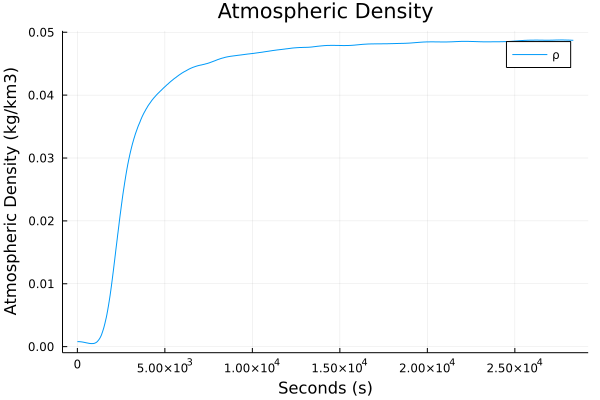

In [104]:
using Plots

t = 1:GPS_num

plot(t, all_states[7,:], title="Atmospheric Density", label= "ρ", xlabel = "Seconds (s)", ylabel= "Atmospheric Density (kg/km3)")

In [105]:
all_states[7,end]

0.04871924020963391

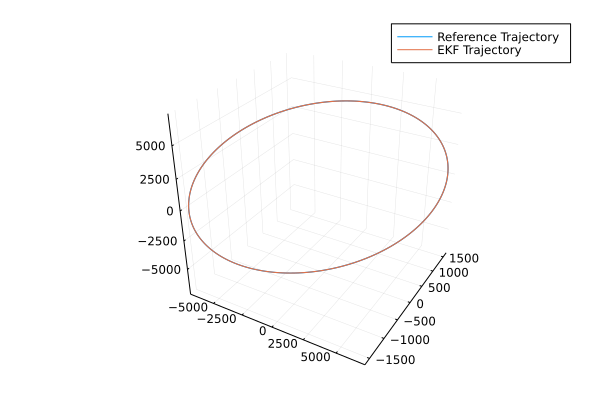

In [106]:
plot(x_hist_scaled[1,:], x_hist_scaled[2,:], x_hist_scaled[3,:], label = "Reference Trajectory")
plot!(all_states[1,:], all_states[2,:], all_states[3,:], label = "EKF Trajectory")

#scatter!([x_hist_scaled[1,1]], [x_hist_scaled[2,1]], [x_hist_scaled[3,1]], xlabel="x (km)", ylabel="y (km)", zlabel="z (km)")

#scatter!([all_states[1,1]], [all_states[2,1]], [all_states[3,1]], label= "Estimated Initial Position")
#xlabel!("x (km)")
#ylabel!("y (km)")
#zlabel!("z (km)")

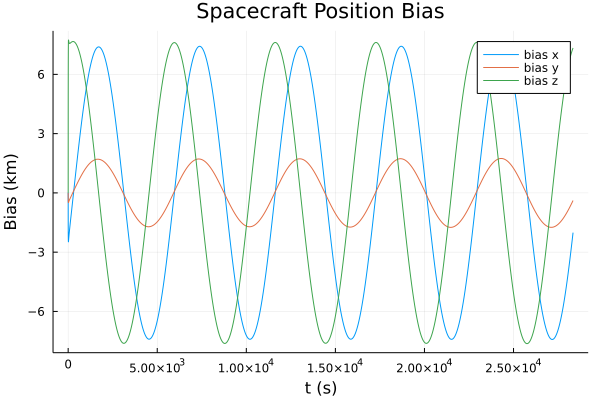

In [107]:
difference = x_hist_scaled[1:3,:] - all_states[1:3,:]
#normz = norm.(eachrow(difference))

#display(x_hist_scaled[1:3,90])
#display(all_states[1:3,90])

plot(t, difference[1,:], label = "bias x", xlabel = "t (s)", ylabel = "Bias (km)", title = "Spacecraft Position Bias")
plot!(t, difference[2,:], label = "bias y")
plot!(t, difference[3,:], label = "bias z")
#normz[end]

In [108]:
display(difference[1,:])

28341-element Vector{Float64}:
  0.015762908232318296
 -1.1947087754215318
 -1.6142590036315596
 -1.8413718165229511
 -1.9983379455688919
 -2.1136037970081816
 -2.210724051708894
 -2.2827017771223836
 -2.3438464429609667
 -2.389711599189468
 -2.4252776026351057
 -2.4512674777579377
 -2.46982862193272
  ⋮
 -2.0988573572958558
 -2.0909579150811624
 -2.083037396009786
 -2.07512100373242
 -2.067220053224446
 -2.059307723866368
 -2.0513899781217333
 -2.0434490452335012
 -2.0355230971026685
 -2.0276046888520796
 -2.0196623764641117
 -2.011728293725355

In [53]:
difference

3×28341 Matrix{Float64}:
 -0.0116679   -1.21461   -1.62398   …  -2.02777   -2.01988   -2.01196
 -0.00656721  -0.239434  -0.321207     -0.391074  -0.389204  -0.38731
 -0.0162251    3.62012    4.8756        7.33093    7.33317    7.33545

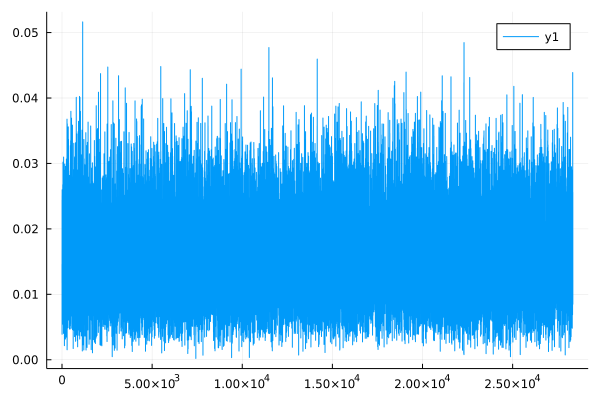

In [54]:
differencegps = GPS_measurments[1:3,:] - x_hist_scaled[1:3,:]
normz_gps = norm.(eachcol(differencegps))

plot(t, normz_gps)

In [55]:
norm(x_hist_scaled[1:3,2] - all_states[1:3,2])

3.8259505602378416

In [56]:
normz[4]

LoadError: UndefVarError: normz not defined

In [51]:
all_states[:,100]

7-element Vector{Float64}:
 -6530.847121346127
 -1535.2400978764204
 -1498.39642439853
    -1.631986718592442
    -0.29429908876216376
     7.426180787069982
     0.0007920778134978737

In [52]:
all_states[:,end]

7-element Vector{Float64}:
 -6431.18170040599
 -1519.3437382075822
 -1839.836422219156
    -2.0079993116634474
    -0.38410520285703786
     7.34211459228155
     0.048726081700534

In [53]:
cov_sqrt_all[1]

7×7 Matrix{Float64}:
 0.01  0.0   0.0   0.0    0.0    0.0    0.0
 0.0   0.01  0.0   0.0    0.0    0.0    0.0
 0.0   0.0   0.01  0.0    0.0    0.0    0.0
 0.0   0.0   0.0   0.001  0.0    0.0    0.0
 0.0   0.0   0.0   0.0    0.001  0.0    0.0
 0.0   0.0   0.0   0.0    0.0    0.001  0.0
 0.0   0.0   0.0   0.0    0.0    0.0    0.00015

In [54]:
cov_sqrt_all[2]

7×7 Matrix{Float64}:
 0.00708864  2.59005e-9  3.84654e-9   …   7.71507e-9    1.51587e-12
 0.0         0.00708863  9.09517e-10      1.82421e-9    8.97442e-15
 0.0         0.0         0.00708863       7.01786e-5   -4.34405e-12
 0.0         0.0         0.0             -1.08491e-9    4.31751e-11
 0.0         0.0         0.0             -2.56614e-10   2.49994e-13
 0.0         0.0         0.0          …   0.000995038  -1.23799e-10
 0.0         0.0         0.0              0.0           0.00015

In [211]:
#in km
R = cov_sqrt_all[end]

sigma_end = R'*R

7×7 Matrix{Float64}:
 2.46005e-7   2.38629e-8    7.21727e-8   …   1.21169e-10   1.22789e-10
 2.38629e-8   1.55388e-7    1.79813e-8       2.96768e-11   2.43964e-11
 7.21727e-8   1.79813e-8    2.14254e-7       1.74974e-10  -4.12076e-11
 4.103e-10    7.33169e-11   1.76013e-10      1.84306e-13   2.36435e-13
 7.26737e-11  1.29471e-10   4.27767e-11      4.42774e-14   3.96804e-14
 1.21169e-10  2.96768e-11   1.74974e-10  …   3.69609e-13  -1.33999e-13
 1.22789e-10  2.43964e-11  -4.12076e-11     -1.33999e-13   4.55837e-11

In [212]:
#overall accuracy is in the centimeter level!!!
sat_final_std = sqrt(tr(sigma_end[1:3, 1:3]))*1e3 #convert back to meters

0.7846319383079297

In [241]:
sqrt(1.18966e-11)*1e3 #uncertainty in the state

0.0034491448215463495

In [242]:
cov_all[end]

7×7 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [243]:
sqrt(5.41032e-7)*1e3

0.7355487747253747

In [244]:
sqrt(0.000236411)

0.015375662587348878

LoadError: UndefVarError: C not defined

In [454]:
X_obs = [true_first_pose[1]+gps_noise[1],true_first_pose[2]+gps_noise[2],true_first_pose[3]+gps_noise[3],true_first_pose[4]+velocity_noise[1],true_first_pose[5]+velocity_noise[2],true_first_pose[6]+velocity_noise[3], initial_ρ]
C_obs = [I zeros((3,4))]
A_obs = find_jacobian(X_obs)

Nu = length(X_obs)

# for k = 1:(Nx-1)
#     C_obs = [C_obs A*C[:,end-(Nx-1):end]]
# end

#create observability matrix 
O = [C_obs; C_obs*A_obs; C_obs*A_obs^2; C_obs*A_obs^3; C_obs*A_obs^4; C_obs*A_obs^5; C_obs*A_obs^6]

display(O)
rank(O)

21×7 Matrix{Float64}:
 1.0         0.0         0.0         …  0.0         0.0          0.0
 0.0         1.0         0.0            0.0         0.0          0.0
 0.0         0.0         1.0            0.0         0.0          0.0
 1.0         3.69651e-7  5.48977e-7     1.23231e-7  1.83047e-7   9.59809e-7
 3.69651e-7  0.999999    1.29807e-7     1.0         4.32488e-8   5.62529e-9
 5.48977e-7  1.29807e-7  1.0         …  4.32488e-8  1.0         -2.75072e-6
 1.0         1.47869e-6  2.19538e-6     9.85851e-7  1.46381e-6   3.83825e-6
 1.47869e-6  0.999998    5.19102e-7     2.0         3.45987e-7   2.22449e-8
 2.19538e-6  5.19102e-7  0.999998       3.45987e-7  2.0         -1.10032e-5
 1.00001     3.32712e-6  4.93922e-6     3.32725e-6  4.93972e-6   8.63532e-6
 3.32712e-6  0.999995    1.16789e-6  …  3.0         1.1677e-6    4.98588e-8
 4.93922e-6  1.16789e-6  0.999996       1.1677e-6   3.0         -2.47575e-5
 1.00002     5.91494e-6  8.7805e-6      7.88682e-6  1.17082e-5   1.5351e-5
 5.91494e-6 

7